---
title       : "Empirical likelihood"
subtitle    :
author      : Paul Schrimpf
date        : `j using Dates; print(Dates.today())`
bibliography: "ee.bib"
---

[![](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-sa/4.0/)

This work is licensed under a [Creative Commons Attribution-ShareAlike
4.0 International
License](http://creativecommons.org/licenses/by-sa/4.0/) 

### About this document {-}

This document was created using Weave.jl. The code is available in
[on github](https://github.com/schrimpf/GMMInference.jl). The same
document generates both static webpages and associated [jupyter
notebook](empiricalLikelihood.ipynb).

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\def\inprob{\,{\buildrel p \over \rightarrow}\,} 
\def\indist{\,{\buildrel d \over \rightarrow}\,} 
$$

In [1]:
markdown = try
  "md" in keys(WEAVE_ARGS) && WEAVE_ARGS["md"]
catch
  false
end

if !("DISPLAY" ∈ keys(ENV))
  ENV["GKSwstype"]="nul"
  ENV["MPLBACKEND"]="Agg"
end

"Agg"

# Empirical likelihood

An interesting alternative to GMM is (generalized) empirical
likelihood (GEL). Empirical likelihood has some appealing higher-order
statistical properties. In particular, it can be shown to have lower
higher order asymptotic bias than GMM. See Newey and Smith
(2004)[@newey2004]. Relatedly, certain test statistics based on EL are
robust to weak identification (Guggenberger and Smith
2005)[@guggenberger2005]. In fact, the identification robust tests
that we have discusses are all based on the CUE-GMM objective
function. The CUE-GMM objetive is a special case of generalized
empirical likelihood.

A perceived downside of GEL is that it involves a more difficult
looking optimization problem than GMM. However, given the ease with
which Julia can solve high dimensional optimization problems, GEL is
very feasible. 

As in the extremum estimation notes, suppose we have moment conditions
such that
$$
\Er[g_i(\theta)] = 0
$$
where $g_i:\R^d \to \R^k$ are some data dependent moment
conditions. The empirical likelihood estimator solves
$$
\begin{align*}
    (\hat{\theta}, \hat{p}) = & \argmax_{\theta,p} \frac{1}{n} \sum_i
    \log(p_i) \;\; s.t.  \\
     & \sum_i p_i = 1, \;\; 0\leq p_i \leq 1 \\
     & \sum_i p_i g_i(\theta) = 0 
\end{align*}
$$

Generalized empirical likelihood replaces $\log(p)$ with some other
convex function $h(p)$, 
$$
\begin{align*}
    (\hat{\theta}^{GEL,h}, \hat{p}) = & \argmin_{\theta,p}
    \frac{1}{n}\sum_i h(p_i) \;\; s.t.  \\
     & \sum_i p_i = 1, \;\; 0\leq p \leq 1 \\
     & \sum_i p_i g_i(\theta) = 0 
\end{align*}
$$
setting $h(p) = \frac{1}{2}(p^2-(1/n)^2)$ results in an estimator
identical to the CUE-GMM estimator.

A common approach to computing GEL estimators is to eliminate $\pi$ by
looking at the dual problem
$$
\hat{\theta}^{GEL}  = \argmin_{\theta}\sup_\lambda \sum_i \rho(\lambda'g_i(\theta))
$$
where $\rho$ is some function related to $h$. See Newey and Smith (2004)[@newey2004] for
details. There can be some analytic advantages to doing so, but
computationally, the original statement of the problem has some
advantages. First, there is more existing software for solving
constrained minimization problems than for solving saddle point
problems. Second, although $p$ is high dimensional, it enters the
constraints linearly, and the objective function is concave. Many
optimization algorithms will take good advantage of this. 

Let's look at some Julia code. Since the problem involves many
variables with linear constraints, it is worthwhile to use JuMP for
optimization. The code is slightly more verbose, but the speed of
JuMP (and the Ipopt solver) are often worth it.

In [2]:
using GMMInference, JuMP, Ipopt, LinearAlgebra, Distributions #, KNITRO 

n = 300
d = 4
k = 2*d
β0 = ones(d)
π0 = vcat(I,ones(k-d,d))
ρ = 0.5
data = IVLogitShare(n, β0, π0, ρ);

┌ Info: Recompiling stale cache file /home/paul/.julia/compiled/v1.2/GMMInference/Fbsdo.ji for GMMInference [bac0df68-cab7-482a-aa4b-d3925df9b168]
└ @ Base loading.jl:1240
┌ Warning: Package GMMInference does not have JuMP in its dependencies:
│ - If you have GMMInference checked out for development and have
│   added JuMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GMMInference
└ Loading JuMP into GMMInference from project dependency, future warnings for GMMInference are suppressed.


In [3]:
# set up JuMP problem
Ty = quantile.(Logistic(),data.y)   
m = Model()
@variable(m, 0.0 <= p[1:n] <= 1.0)
@variable(m, θ[1:d])
@constraint(m, prob,sum(p)==1.0)
@constraint(m, momentcon[i=1:k], dot((Ty - data.x*θ).*data.z[:,i],p)==0.0)
@NLobjective(m,Max, sum(log(p[i]) for i in 1:n))
m

A JuMP Model
Maximization problem with:
Variables: 304
Objective function type: Nonlinear
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`GenericQuadExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 8 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 300 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 300 constraints
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: momentcon, p, prob, θ

The `gel_jump_problem` function from `GMMInference.jl` does the same
thing as the above code cell. 

Let's solve the optimization problem.

In [4]:
set_optimizer(m, with_optimizer(Ipopt.Optimizer, print_level=5))
set_start_value.(m[:θ], 0.0)
set_start_value.(m[:p], 1/n)
optimize!(m)
@show value.(m[:θ])
@show value.(m[:p][1:10])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    21900
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9900

Total number of variables............................:      304
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equ

10-element Array{Float64,1}:
 0.0032408776554103996
 0.003362295758281996 
 0.0032159594738521233
 0.0031567334382483344
 0.00333982372136344  
 0.003467428063430768 
 0.0033503401839802133
 0.003353318300356691 
 0.0033152975735406447
 0.0030786808157137954

For comparison here is how long it takes JuMP + Ipopt to solve for the
CUE-GMM estimator.

In [5]:
@show mcue = gmm_jump_problem(data, cue_objective)
set_start_value.(mcue[:θ], 0.0)
set_optimizer(mcue,  with_optimizer(Ipopt.Optimizer,print_level=5))
optimize!(mcue)
@show value.(mcue[:θ])

mcue = gmm_jump_problem(data, cue_objective) = A JuMP Model
Minimization problem with:
Variables: 4
Objective function type: Nonlinear
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: θ
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequali

4-element Array{Float64,1}:
 0.9823493140389612
 0.9739053268783593
 1.0944386815890932
 0.9568887959355561

In this comparison, EL is both faster and more robust to initial
values than CUE-GMM. GMM with a fixed weighting matrix will likely be
faster than either.

## GEL with other optimization packages

We can also estimate GEL models with other optimization
packages. Relative to JuMP, other optimization packages have the
advantage that the problem does not have to be written in any special
syntax. However, other packages have the downside that they will not
recognize any special structure in the constraints (linear, quadratic,
sparse, etc) unless we explicitly provide it. Let's see how much, if
any difference this makes to performance. 

Here we will use the `NLPModels.jl` interface to
Ipopt. Essentially, all this does is call `ForwardDiff` on the
objective function and constraints, and then give the resulting
gradient and hessian functions to Ipopt.

In [6]:
using NLPModelsIpopt, NLPModels #NLPModelsKnitro, 
gel = gel_nlp_problem(data)
ip = ipopt(gel)

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2736
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    46360

Total number of variables............................:      304
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      304
                     variables with only upper bounds:        0
Total number of equality constraints.................:        9
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

"Execution stats: first-order stationary"

As you see, this approach is far slower than with JuMP. Notice that
the number of iterations and function evaluations are identical. The
big difference is that JuMP evaluates the function (and its
derivatives) very quickly, while NLP takes much much longer. I would
guess that this is largely because it is using ForwardDiff to
calculate a gradients and hessians for 304 variables.

Let's also estimate the model using `Optim.jl`.

In [7]:
using Optim
args = gel_optim_args(data)
@time opt=optimize(args[1],args[2],
                   [fill(1/(1.1*n),n)..., zeros(d)...],
                   IPNewton(μ0=:auto, show_linesearch=false),
                   Optim.Options(show_trace=true,
                                 allow_f_increases=true,
                                 successive_f_tol=10,
                                 allow_outer_f_increases=true))
@show opt.minimizer[(n+1):end]

Iter     Lagrangian value Function value   Gradient norm    |==constr.|      μ
     0   8.813392e+03     1.739728e+03     5.926114e+04     7.059412e+03     8.18e-03
 * time: 1.572236833244511e9
     1   6.142549e+03     1.733971e+03     2.838844e+05     4.407156e+03     8.18e-04
 * time: 1.572236834341403e9
     2   4.696478e+03     1.739712e+03     2.406647e+05     2.955045e+03     9.82e-04
 * time: 1.572236834353161e9
     3   4.464908e+03     1.743273e+03     2.761810e+05     2.719380e+03     1.28e-03
 * time: 1.572236834375124e9
     4   2.599156e+03     1.857212e+03     7.368077e+05     7.396571e+02     1.23e-03
 * time: 1.57223683438491e9
     5   2.312813e+03     1.965302e+03     5.250859e+05     3.456431e+02     9.46e-04
 * time: 1.572236834403165e9
     6   2.308714e+03     1.968818e+03     5.114747e+05     3.374695e+02     1.22e-03
 * time: 1.572236834411261e9
     7   2.266305e+03     2.024368e+03     3.713212e+05     2.396530e+02     1.12e-03
 * time: 1.572236834419367e9
  

4-element Array{Float64,1}:
 0.9814563419868797
 0.9777834892154721
 1.0951373719239965
 0.9549048405684423

The `IPNewton()` optimizer from `Optim.jl` appears to be much less
efficient than `Ipopt`. `IPNewton` takes more than 4 times as many
iterations. 

# Inference for EL

Guggenberger and Smith (2005)[@guggenberger2005] show that GEL
versions of the AR and LM statistics are robust to weak
identification. The GEL version of the AR statistic is the generalized
empirical likelihood ratio. Guggenberger and Smith (2005) show that

$$
GELR(\theta_0) = 2\sum_{i=1}^n\left(h(p_i(\theta_0))  -
   h(1/n)\right) \indist \chi^2_k 
$$

where $p_i(\theta_0)$ are given by

$$
\begin{align*}
    p(\theta)  =  \argmax_{0 \leq p \leq 1} \sum h(p_i) \text{ s.t. } & \sum_i p_i
    = 1 \\
& \sum_i p_i g_i(\theta) = 0
\end{align*}
$$

The GELR statistic shares the downsides of the AR statistic --- the
degrees of freedom is the number of moments instead of the number of
parameters, which tends to lead to lower power in overidentified
models; and it combines a test of misspecification with a location
test for $\theta$. 

Consequently, it can be useful to instead look at a Lagrange
multiplier style statistic. The true $\theta$ maximizes the
empirical likelihood, so 

$$
0 = \sum_{i=1}^n \nabla_\theta h(p_i(\theta_0)) = \lambda(\theta_0)' \sum_{i=1}^n
p_i(\theta_0) \nabla_\theta g_i(\theta_0) \equiv \lambda(\theta_0) D(\theta_0)
$$

where $p_i(\theta_0)$ is as defined above, and $\lambda(\theta_0)$ are
the mulitpliers on the empirical moment condition constraint. Andrews
and Guggenberger show that a quadratic form in the above score
equation is asymptotically $\chi^2_d$. To be specific, let
$\Delta(\theta) = E[(1/n\sum_i g_i(\theta) - E[g(\theta)])(1/n \sum_i
 g_i(\theta) - E[g(\theta)])']$  and define

$$
S(\theta) = n\lambda(\theta)' D(\theta) \left( D(\theta)
\Delta(\theta)^{-1} D(\theta) \right)^{-1} D(\theta)'\lambda(\theta)
$$

then $S(\theta_0) \indist \chi^2_d$. This result holds whether or not
$\theta$ is strongly identified. 

### Implementation

Computing the $GELR$ and $S$ statistics requires solving a linear
program for each $\theta$ we want to test. Fortunately, linear
programs can be solved very quickly. See `gel_pλ` in `GMMInference.jl`
for the relevant code. 

Let's do a simulation to check that these tests have correct coverage.

Combined backtracking failed 0 0 90 0 sigma 1
Combined backtracking failed 0 0 90 0 sigma 1


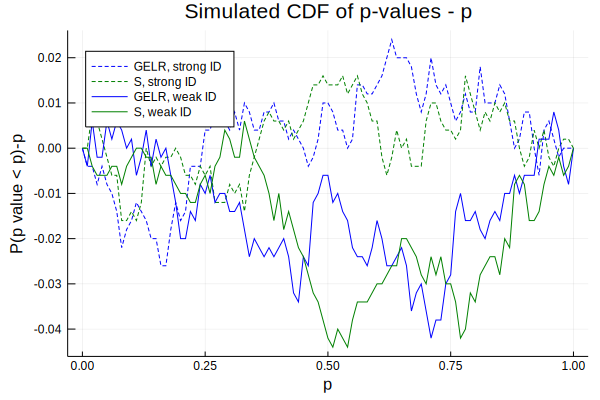

In [8]:
using Plots
Plots.gr()
S = 500
n = 200
d = 2
β0 = ones(d)
ρ = 0.5
k = 3
function sim_p(π0)
  data = IVLogitShare(n, β0, π0, ρ)
  GELR, S, plr, ps = gel_tests(β0, data)
  [plr ps]
end
πweak = ones(k,d) .+ vcat(diagm(0=>fill(0.01,d)),zeros(k-d,d))  
πstrong = vcat(5*diagm(0=>ones(d)),ones(k-d,d)) 
pweak=vcat([sim_p(πweak ) for s in 1:S]...)
pstrong=vcat([sim_p(πstrong) for s in 1:S]...)

pgrid = 0:0.01:1
plot(pgrid, p->(mean( pstrong[:,1] .<= p)-p), legend=:topleft,
     label="GELR, strong ID", style=:dash, color=:blue,
     xlabel="p", ylabel="P(p value < p)-p",
     title="Simulated CDF of p-values - p")  
plot!(pgrid, p->(mean( pstrong[:,2] .<= p)-p),
      label="S, strong ID", style=:dash, color=:green)

plot!(pgrid, p->(mean( pweak[:,1] .<= p)-p),
      label="GELR, weak ID", style=:solid, color=:blue)
plot!(pgrid, p->(mean( pweak[:,2] .<= p)-p),
      label="S, weak ID", style=:solid, color=:green)
plot!(pgrid,0,alpha=0.5, label="")

### Subvector inference

Guggenberger and Smith (2005)[@guggenberger2005] also give results for
subvector inference. Let $(\alpha, \beta) =\theta$. Assume $\beta$ is
strongly identified. Guggenberger and Smith show that analogs of
$GELR$ and $S$ with $\beta$ concentrated out lead to valid tests for
$\alpha$, whether $\alpha$ is weakly or strongly identified. 


## Bootstrap for EL

For bootstrapping GMM, we discussed how it is important that the null
hypothesis holds in the bootstrapped data. In GMM we did this by
substracting the sample averages of the moments. In GEL, an
alternative way to impose the null, is to sample the data with
probabilities $\hat{p}_i$ instead of with equal proability. See
Brown and Newey (2002)[@brown2002] for more information. 


# References

\bibliography